### Working with Google Colaboratory
If you decide to work with Google Colaboratory (recommended because it comes with `pyTorch` installed and the possibility to use GPU for computations), you need to run the next code block before you start working with the notebook.

To get a better idea of what the code below is doing, have a look at this [introductory video](https://cs231n.github.io/setup-instructions/) from the CS231n Standford course.

If you need to install additional packages on Google Colaboratory (it should not needed for this assignment) you can do it from the notebook with `!pip install name_package`

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the material for this assignment,
# e.g. 'cvf20/assignments/assignment3/'
FOLDERNAME = "CVF/ex03/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Make sure that the python modules in the assignment folder are found by the notebook:
import sys
import os
path_drive = os.path.join("/content/drive/My\ Drive", FOLDERNAME)
sys.path.append(path_drive)

# Copy the yeast-cells data in the content folder of the notebook:
dataset_path = os.path.join(path_drive, "yeast_cells_dataset") 
!cp -r $dataset_path ./

# Move to the main content folder:
%cd /content



Mounted at /content/drive
/content


# 1. Parameters and Receptive Field of a CNN
*Insert your answer here (or in a seperate `.pdf` file).*

In [2]:
print("\nPart (a)\n")

c1 = (5*5*3)*32
c2 = (3*3*32)*32
c3 = (3*3*33)*64
c4 = (3*3*64)*64
c5 = (3*3*64)*128
c_total = c1+c2+c3+c4+c5
print("Total number of parameters in 5 convolutional layers =",c_total)
f1 = (3*3*128)*512
f2 = 512 * 10
f_total = f1+f2
print("Total number of parameters in 2 fully connected layers =",f_total)
print("No parameters required in ReLu, MaxPool and Softmax since they are all parameter-free activation functions.")
print("Hence, the total number of learnable parameters in the entire architecture is the sum of parameters in the convolutional layers and the fully connected layers. \nAns =",c_total+f_total)


print("\nPart (b)\n")

c_output = 3*3*128
print("Output of the convolutional part of the model (3*3*128) = ", c_output)
rf_theoretical = (56+2*6)*(56+2*6)
print("Theoretical receptive field before fully connected layers = ",rf_theoretical)
print("\nIn our model, the convolution output is assumed to have the same spatial dimension as input image (56*56) since the input is always padded with zeros.\n"
"As seen in the example, 2 layers of 3x3 kernel is equivalent to 1 layer of 5x5, so in the system we have (2+4) layers of 3x3 convolution. \n"
"Each 3x3 convolution layer will effectively require the input size to be padded with 2 extra pixels on each dimension, hence (56+2*6)*(56+2*6). \n"
)


Part (a)

Total number of parameters in 5 convolutional layers = 141216
Total number of parameters in 2 fully connected layers = 594944
No parameters required in ReLu, MaxPool and Softmax since they are all parameter-free activation functions.
Hence, the total number of learnable parameters in the entire architecture is the sum of parameters in the convolutional layers and the fully connected layers. 
Ans = 736160

Part (b)

Output of the convolutional part of the model (3*3*128) =  1152
Theoretical receptive field before fully connected layers =  4624

In our model, the convolution output is assumed to have the same spatial dimension as input image (56*56) since the input is always padded with zeros.
As seen in the example, 2 layers of 3x3 kernel is equivalent to 1 layer of 5x5, so in the system we have (2+4) layers of 3x3 convolution. 
Each 3x3 convolution layer will effectively require the input size to be padded with 2 extra pixels on each dimension, hence (56+2*6)*(56+2*6). 



# 2. Train a CNN for Semantic Segmentation (Part 1)

In [0]:
# The usual first imports:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.ndimage
plt.rcParams['figure.figsize'] = [15, 15]

import torch
import h5py
import os


### a) Loading the data
You can find the data in the `yeast_cells_dataset` folder, including both the input images and associated ground labels. In this first part of the exercise, we want to create a single file called `yeast_cells_dataset/dataset.hdf5` with the following specifications:

- the HDF5 file should have two internal datasets called `raw` and `gt` (see a quick introduction [here](http://docs.h5py.org/en/stable/quick.html) if you have never used the library `h5py`)
- each dataset should have 3 dimensions with shape (nb_images, x_shape, y_shape) = (18, 920, 1760): the first dimension represents the image index (there are 18 images in total), whereas the second and third ones are equal to the resolution of the images.
- When you create the datasets with the h5py `create_dataset()` function, make sure to use the argument `compression='gzip'` so that the resulting file has a small size

Implement the function below and then test it with `check_dataset()`.

**Important**: if the `.hdf5` files you create are too big, you don't need to include them in your submission (same for the folder with the `.png` images). However, your notebook should show all your results and your plots. If we need to re-run your notebook, we will make sure that the original `yeast_cells_dataset` folder with the `.png` images is found.

In [4]:
def create_hdf5_dataset():
    ### Start of your code ###

    prefix = './yeast_cells_dataset/'
    with h5py.File(prefix+"dataset.hdf5", "w") as f:
      for j in ['raw','gt']:
        dset = f.create_dataset(j, (18,920,1760), compression="gzip")
        for i in range(18):
          dset[i,:,:] = plt.imread(prefix+j+"_{}.png".format(i))

    ### End of your code ###


def check_dataset():
    path = './yeast_cells_dataset/dataset.hdf5'
    assert os.path.exists(path), "Dataset does not exists"
    
    with h5py.File(path, 'r') as f:
        assert "raw" in f, "Raw dataset not found in .hdf5 file"
        assert "gt" in f, "GT dataset not found in .hdf5 file"
        assert f["raw"].ndim == 3, "Wrong nb of dimensions"
        assert f["gt"].ndim == 3, "Wrong nb of dimensions"
        assert f["raw"].shape == (18, 920, 1760), "Wrong shape"
        assert f["gt"].shape == (18, 920, 1760), "Wrong shape"
        
    print("Hdf5 dataset correctly created!")

        
create_hdf5_dataset()
check_dataset()

Hdf5 dataset correctly created!


### b) Normalization
Complete the code below to normalize the dataset and after doing it print the mean and the standard deviation before and after normalizing it.

In [5]:
def normalize_hdf5_dataset():
    """
    TODO: print the mean and the standard deviation before and after normalizing the raw data
    """
    original_path = './yeast_cells_dataset/dataset.hdf5'
    new_path = './yeast_cells_dataset/dataset_normalized.hdf5'
    
    ### Start of your code ###
    original = h5py.File(original_path,"r")

    with h5py.File(new_path, "w") as new:
      for j in ['raw','gt']:
        dset = new.create_dataset(j, (18,920,1760), compression="gzip")
        for i in range(18):
          mean = original[j][i,:,:].mean()
          sigma = original[j][i,:,:].std()
          print("original_"+j+"_{}, mean={},sigma={}".format(i,round(mean,1),round(sigma,1)))
          new[j][i,:,:] = (original[j][i,:,:] - mean)/sigma
          mean_new = new[j][i,:,:].mean()
          sigma_new = new[j][i,:,:].std()
          print("normalized_"+j+"_{}, mean={},sigma={}".format(i,round(mean_new,1),round(sigma_new,1)))

    ### End of your code ###

normalize_hdf5_dataset()

original_raw_0, mean=0.4000000059604645,sigma=0.0
normalized_raw_0, mean=-0.0,sigma=1.0
original_raw_1, mean=0.4000000059604645,sigma=0.10000000149011612
normalized_raw_1, mean=-0.0,sigma=1.0
original_raw_2, mean=0.4000000059604645,sigma=0.10000000149011612
normalized_raw_2, mean=0.0,sigma=1.0
original_raw_3, mean=0.4000000059604645,sigma=0.0
normalized_raw_3, mean=-0.0,sigma=1.0
original_raw_4, mean=0.4000000059604645,sigma=0.10000000149011612
normalized_raw_4, mean=0.0,sigma=1.0
original_raw_5, mean=0.4000000059604645,sigma=0.10000000149011612
normalized_raw_5, mean=-0.0,sigma=1.0
original_raw_6, mean=0.4000000059604645,sigma=0.0
normalized_raw_6, mean=0.0,sigma=1.0
original_raw_7, mean=0.4000000059604645,sigma=0.10000000149011612
normalized_raw_7, mean=-0.0,sigma=1.0
original_raw_8, mean=0.4000000059604645,sigma=0.10000000149011612
normalized_raw_8, mean=0.0,sigma=1.0
original_raw_9, mean=0.4000000059604645,sigma=0.10000000149011612
normalized_raw_9, mean=-0.0,sigma=1.0
original_raw

### c) Data augmentation
**Task 1** -- We first want to create a `PyTorch` dataset from the data we loaded previously, using the `torch.utils.data.dataset` class.

When we train our CNN model, we want to first crop the yeast-cells images to a fixed shape of $(512x512)$. The classes `ImagesFromH5File` and `YeastCellDataset` (see the `cvf20/datasets.py` file) are exactly doing that and expects the path to a `.hdf5` file like the one you created previously. 

Read the documentation of the `YeastCellDataset` class (see `cvf20/datasets.py`) and create the PyTorch dataset in the code below. As `stride`, you can use (32, 32).

/content


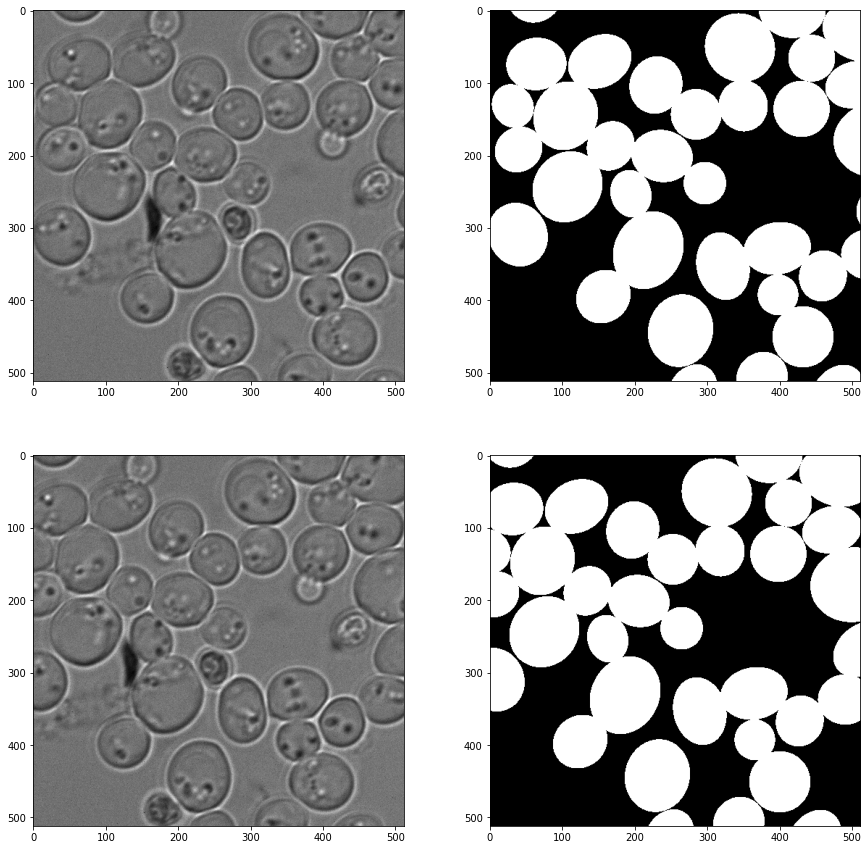

In [12]:
#%cd /content/drive/My\ Drive/CVF/ex03
%cd /content

from cvf20.datasets import YeastCellDataset

### Start of your code ###
# dataset = YeastCellDataset(...)
# dataset = None

dataset = YeastCellDataset(path_h5_file='./yeast_cells_dataset/dataset_normalized.hdf5', window_size = (512,512), stride=(32, 32), mode="train", transforms=None)

### End of your code ###


# Validate your code and plot some images:
if dataset is not None:
    assert dataset[0][0].shape == (512, 512)

    f, ax = plt.subplots(ncols=2, nrows=2)
    ax[0,0].imshow(dataset[0][0], cmap='gray')
    ax[0,1].imshow(dataset[0][1], cmap='gray')
    ax[1,0].imshow(dataset[1][0], cmap='gray')
    ax[1,1].imshow(dataset[1][1], cmap='gray')
    plt.show()


In [0]:
!pwd

/content


**Task 2** -- Now that you created the dataset, let's add some more data augmentation to it!

In the `cvf20/transforms.py` file you can find an example of transformation you should implement: the class `DownscaleImage` is, as you would expect, downscaling an image by a given factor (by first applying a filter to it). Tranformations are usually not applied to all images in the dataset, but they are randomly applied with a certain probability. In order to understand the functionality of the `build_random_variables()` method you can have a look at the parent tranform class `BasicTransform2D` (also in `cvf20/transforms.py`).

In the code block below, implement two additional transformations that should: i) reflect an image along x and/or along y with probability 0.5; ii) randomly rotate an image of a multiple of 90 degrees. In the next code block, you can plot some images and check if your transformations are applied correctly.

In [0]:
import cvf20.transforms as T

class RandomFlip(T.BasicTransform2D):
    def build_random_variables(self):
        ### Start of your code ###
        self._random_variables = {
            "apply_flip_x": np.random.random()<0.5,
            "apply_flip_y": np.random.random()<0.5
        }
        ### End of your code ###
        
    def apply_transform_to_image(self, image):
        assert image.ndim == 2
        ### Start of your code ###
        if self.get_random_variable("apply_flip_x"):
            image = np.flip(image,0)
        if self.get_random_variable("apply_flip_y"):
            image = np.flip(image,1)
        ### End of your code ###
        return image


class RandomRotation(T.BasicTransform2D):
    def build_random_variables(self):
        ### Start of your code ###
        self._random_variables = {
            "apply_rotation": np.random.randint(0,4)
        }
        ### End of your code ###

    def apply_transform_to_image(self, image):
        assert image.ndim == 2
        ### Start of your code ###
        n = self.get_random_variable("apply_rotation")
        image = np.rot90(image,n)
        ### End of your code ###
        return image
    
all_transforms = T.Compose(
    RandomFlip(),
    RandomRotation()
)

In [32]:
a = np.arange(16).reshape((4,4))
print(a)
a= np.flip(a,0)
print(a)
a = np.rot90(a,1)
print(a)

dataset[0][0].shape

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[12 13 14 15]
 [ 8  9 10 11]
 [ 4  5  6  7]
 [ 0  1  2  3]]
[[15 11  7  3]
 [14 10  6  2]
 [13  9  5  1]
 [12  8  4  0]]


(512, 512)

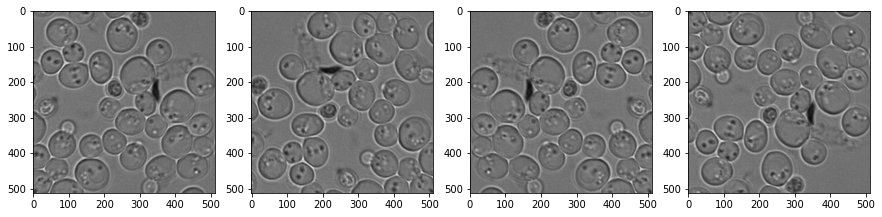

In [36]:
from cvf20.datasets import YeastCellDataset

### Start of your code ###
#dataset_with_transforms = None
dataset_with_transforms = YeastCellDataset(path_h5_file='./yeast_cells_dataset/dataset_normalized.hdf5', window_size = (512,512), stride=(32, 32), mode="train", transforms=all_transforms)

### End of your code ###

# Validate your code and plot some images:
if dataset_with_transforms is not None:
    assert dataset_with_transforms[0][0].shape == (512, 512)

    f, ax = plt.subplots(ncols=4)
    ax[0].imshow(dataset_with_transforms[0][0], cmap='gray')
    ax[1].imshow(dataset_with_transforms[0][0], cmap='gray')
    ax[2].imshow(dataset_with_transforms[0][0], cmap='gray')
    ax[3].imshow(dataset_with_transforms[0][0], cmap='gray')
plt.show()


**Task 3** -- Finally, we will now create a PyTorch `DataLoader` that will take care of randomly selecting some of the crops in the dataset. The shape of the PyTorch tensors that we will feed to the neural network is the following: `(batch_size, nb_channels, x_size, y_size)`. The dimension of the tensor is 4 because we are dealing with 2D images.  `nb_channels` for the input image is 1, because it has only one channel.

In [0]:
from torch.utils.data.dataloader import DataLoader

all_transforms = T.Compose(
    RandomFlip(),
    RandomRotation(),
    T.ToTorchTensor()
)

### Start of your code ###
dataset_with_transforms = YeastCellDataset(path_h5_file='./yeast_cells_dataset/dataset_normalized.hdf5', window_size = (512,512), stride=(32, 32), mode="train", transforms=all_transforms)
### End of your code ###

# Create the data loader:
assert dataset_with_transforms is not None
dataset_loader = DataLoader(
        dataset_with_transforms, 
        batch_size=4,
        shuffle=True,
        drop_last=True,
        num_workers=2
)

# Validate your code:
for raw, gt in dataset_loader:
    assert isinstance(raw, torch.Tensor)
    assert raw.shape == (4,1,512,512)

### d) Semantic Segmentation Metrics
In the code below, implement the two metrics described in the exercise sheet. After implementing it, run the next code block to test your functions on a small 5x5 image.

*Remark*: now the images (prediction of the CNN model and ground truth labels) are `PyTorch` tensors and not `numpy` arrays. Most of the functions in `PyTorch` to perform matrix and vector operations are very similar to the ones you used in `numpy`.

In [0]:
def compute_accuracy(predictions, targets):
    """
    The shape of both `predictions` and `targets` should be (batch_size, nb_classes, x_size_image, y_size_image)
    """
    assert isinstance(predictions, torch.Tensor)
    assert isinstance(targets, torch.Tensor)
    assert predictions.ndim == 4 and targets.ndim == 4
    
    ### Start of your code ###
    accuracy = None
    pass
    ### End of your code ###
    
    return accuracy
    

def compute_IoU(predictions, targets):
    """
    The shape of both `predictions` and `targets` should be (batch_size, nb_classes, x_size_image, y_size_image)
    """
    assert isinstance(predictions, torch.Tensor)
    assert isinstance(targets, torch.Tensor)
    assert predictions.ndim == 4 and targets.ndim == 4
    
    ### Start of your code ###
    IoU = None
    pass
    ### End of your code ###
    
    return IoU

In [0]:
# Create a small 5x5 example to test the metrics above:
test_pred, test_gt = torch.zeros((2,5,5)), torch.zeros((2,5,5))
test_pred[0,0,:3] = 0.8
test_gt[0,0,2:] = 1
test_pred[1] = 1. - test_pred[0]
test_gt[1] = 1. - test_gt[0]
test_pred = test_pred.unsqueeze(0)
test_gt = test_gt.unsqueeze(0)

print(compute_accuracy(test_pred, test_gt))
print(compute_IoU(test_pred, test_gt))

None
None
